In [1]:
data_dir = '../data'
image_dir = '../images'
data_file_name_clean = "BankChurners_clean.csv"

In [2]:
import pandas as pd
import numpy as np

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To define maximum number of columns to be displayed in a dataframetest
pd.set_option("display.max_columns", None)

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target, name='', other={}):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    info = other.copy()
    info.update({
        "Accuracy": round(acc, 3),
        "Recall": round(recall, 3),
        "Precision": round(precision, 3),
        "F1": round(f1, 3),
    })


    # creating a dataframe of metrics
    df_perf = pd.DataFrame(info,index=[name])

    return df_perf

def confusion_matrix_sklearn(model, predictors, target, figsize=(6, 4),
                             rotation_x = 0, rotation_y=0, cmap='Blues', name='', test_or_train=''):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            [f"{item:,}"+ f"\n\n{item / cm.flatten().sum():.1%}"]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, annot=labels, fmt="", square = True, cmap=cmap,
                     linewidth=2)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_x, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation_y)
    plt.title(f'Confusion Matrix\n{name}\n{test_or_train} Data')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tick_params(left=False, bottom=False)
    name_modified = name.replace('\n', '_')
    plt.savefig(f"{image_dir}/confusion_matrix_{name_modified}_{test_or_train}.png", bbox_inches='tight');

def add_dummies(df, cols=[]):
  df = pd.get_dummies(df, drop_first=True)
  df = df.astype('float')
  if cols:
    cols_not_in_df = [c for c in cols if c not in df.columns]
    for c in cols_not_in_df:
      df[c] = 0
    return df[cols]
  return df

def impute_given_data(df):
  cols_to_impute = df.columns[df.isnull().sum()>0].tolist()
  cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

  df_imputed = df.copy()
  for col in cols_to_impute:
    strategy = 'most_frequent' if col in cat_cols else 'mean'
    imputer = SimpleImputer(strategy=strategy)
    df_imputed[[col]] = imputer.fit_transform(df_imputed[[col]])
  return df_imputed


def plot_feature_importance(model, feature_names, figsize=(4, 8),
                            color = 'skyblue',
                            alpha = 0.6,
                            name=''):
  """
  Importance of features in the tree building.
  (The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.
  It is also known as the Gini importance.)
  """


  importances = model.feature_importances_
  indices = np.argsort(importances)

  importance_df = (
      pd.DataFrame(
          importances, columns=["Importance"], index=feature_names
      ).sort_values(by="Importance", ascending=False)
  )
  importance_df.index.name = "Feature"

  display(importance_df)

  plt.figure(figsize=figsize)

  # yticks = range(len(indices))
  # ylabels = [feature_names[i] for i in indices]
  # plt.barh(yticks, importances[indices], color=color, align="center")
  # plt.yticks(ticks=yticks, labels=ylabels)

  sns.barplot(y=feature_names, x=importances, color=color, alpha=alpha,
              order=importance_df.sort_values(by="Importance", ascending=False).index)

  plt.xlabel("Relative Importance")
  plt.ylabel("Features", rotation=90)
  sns.despine(top = True, right = True)
  # plt.title(f"Feature Importances\n{name} Decision Tree Model")
  plt.title(f"Feature Importances\n{name}")
  plt.savefig(f"{image_dir}/feature_importances_{name}.png", bbox_inches='tight');

def get_model_name(model):
  return model.__class__.__name__

def get_params_df(selected):
  # return pd.DataFrame.from_dict(selected.get_params(), orient='index', columns=['Values']).rename_axis(get_model_name(selected))
  return pd.DataFrame.from_dict(selected.get_params(), orient='index', columns=[get_model_name(selected)]).T

In [4]:
dtype = {'Attrition_Flag': 'category'}

In [5]:
data_orig= pd.read_csv(f'{data_dir}/{data_file_name_clean}', dtype=dtype)

In [6]:
data_orig.shape

(10127, 20)

In [7]:
data = data_orig.copy()

In [8]:
data.shape

(10127, 20)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Avg_Open_To_Buy           10127 non-null  float64 
 2   Avg_Utilization_Ratio     10127 non-null  float64 
 3   Card_Category             10127 non-null  object  
 4   Contacts_Count_12_mon     10127 non-null  int64   
 5   Credit_Limit              10127 non-null  float64 
 6   Customer_Age              10127 non-null  int64   
 7   Dependent_count           10127 non-null  int64   
 8   Education_Level           10127 non-null  object  
 9   Gender                    10127 non-null  object  
 10  Income_Category           10127 non-null  object  
 11  Marital_Status            10127 non-null  object  
 12  Months_Inactive_12_mon    10127 non-null  int64   
 13  Months_on_book            10127 non-null  int6

## missing values

In [10]:
# let's check for missing values in the data
out = data.isnull().sum().sort_values(ascending=False)
out.name = 'Null Count'
out.index.name = 'Column'
display(out[out>0])

out = (100*data.isnull().sum().sort_values(ascending=False)/data.shape[0]).round(2)
out.name = 'Null Proportion %'
out.index.name = 'Column'
display(out[out>0])

Series([], Name: Null Count, dtype: int64)

Series([], Name: Null Proportion %, dtype: float64)

## outliers

In [11]:
# checking the % outliers
data_numeric = data.select_dtypes(include=["float64", "int64"])

Q1 = data_numeric.quantile(0.25)  # To find the 25th percentile
Q3 = data_numeric.quantile(0.75)  # To find the 75th percentile

IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

# Finding lower and upper bounds for all values. All values outside these bounds are outliers
lower = (Q1 - 1.5 * IQR)
upper = (Q3 + 1.5 * IQR)

# cols = [c for c in data_numeric.columns if not data[c].nunique() < 7]
# data_numeric = data_numeric[cols]
outliers = (data_numeric < lower) | (data_numeric > upper)
outlier_count = outliers.sum(axis=1)
outlier_rows = data[outlier_count > 0]
out = outliers.sum() / len(data) * 100
out.index.name='Column'
out.name='Outlier %'
out.sort_values(ascending=False, inplace=True)
display(out[out>0])
outlier_columns = out[out>0].index.tolist()

data_new = data.copy()

for col in outlier_columns:
  if col == 'Credit_Limit':
    continue
  r0 = data_new.shape[0]
  data_new = data_new[(data_new[col] >= lower[col]) & (data_new[col] <= upper[col])]
  r1 = data_new.shape[0]
  print(col, round((r0-r1)/float(r0),2))

Column
Credit_Limit             9.717
Avg_Open_To_Buy          9.509
Total_Trans_Amt          8.848
Contacts_Count_12_mon    6.211
Total_Amt_Chng_Q4_Q1     3.910
Total_Ct_Chng_Q4_Q1      3.891
Months_on_book           3.812
Months_Inactive_12_mon   3.268
Customer_Age             0.020
Total_Trans_Ct           0.020
Name: Outlier %, dtype: float64

Avg_Open_To_Buy 0.1
Total_Trans_Amt 0.08
Contacts_Count_12_mon 0.06
Total_Amt_Chng_Q4_Q1 0.04
Total_Ct_Chng_Q4_Q1 0.03
Months_on_book 0.04
Months_Inactive_12_mon 0.03
Customer_Age 0.0
Total_Trans_Ct 0.0


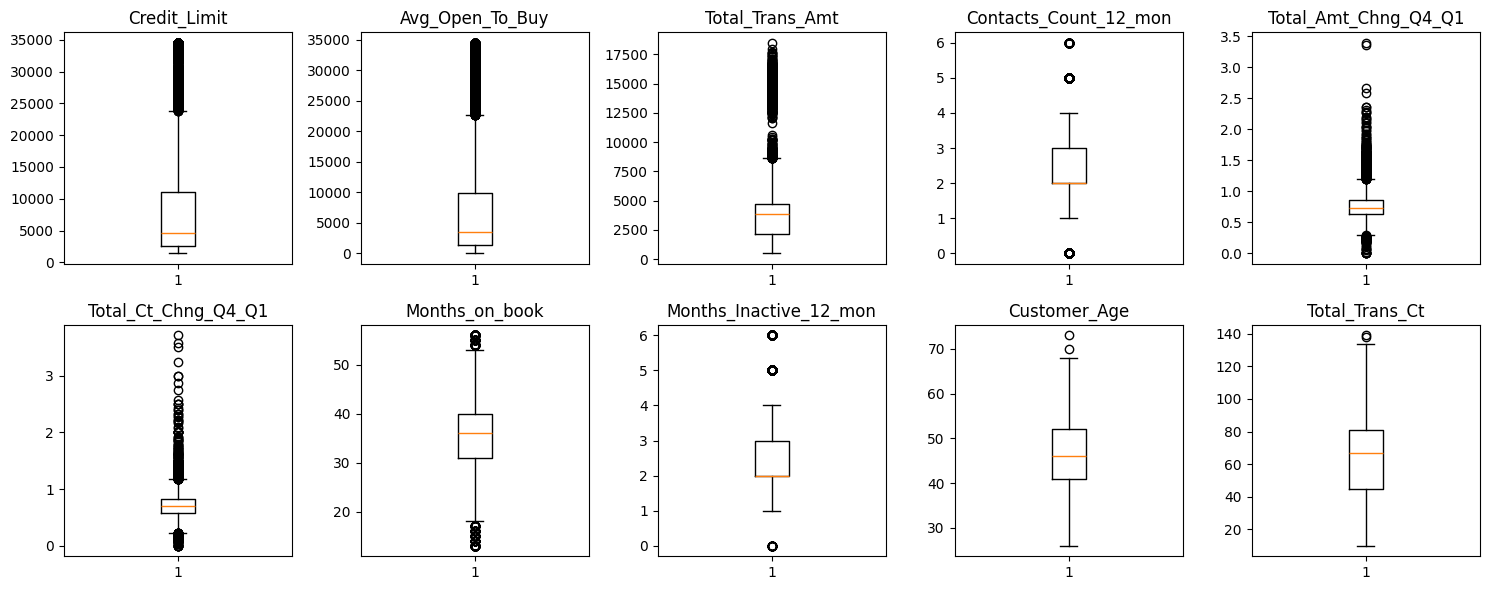

In [12]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 6))

for i, variable in enumerate(outlier_columns):
    plt.subplot(2, 5, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [13]:
# Perfect Multicollinearity
cols_to_drop = ['Credit_Limit', 'Months_on_book'] # high correlation with Credit_Limit

In [14]:
df = data.drop(cols_to_drop, axis=1)

In [15]:
df.to_csv(f'{data_dir}/Churn_read_for_modeling.csv', index=False)

In [16]:
df = pd.read_csv(f'{data_dir}/Churn_read_for_modeling.csv')

In [17]:
df.head()

,Attrition_Flag,Avg_Open_To_Buy,Avg_Utilization_Ratio,Card_Category,Contacts_Count_12_mon,Customer_Age,Dependent_count,Education_Level,Gender,Income_Category,Marital_Status,Months_Inactive_12_mon,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Total_Relationship_Count,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
0,0,11914.000,0.061,Blue,3,45,3,High School,M,$60K - $80K,Married,1,1.335,1.625,5,777,1144,42
1,0,7392.000,0.105,Blue,2,49,5,Graduate,F,Less than $40K,Single,1,1.541,3.714,6,864,1291,33
2,0,3418.000,0.000,Blue,0,51,3,Graduate,M,$80K - $120K,Married,1,2.594,2.333,4,0,1887,20
3,0,796.000,0.760,Blue,1,40,4,High School,F,Less than $40K,Unknown,4,1.405,2.333,3,2517,1171,20
4,0,4716.000,0.000,Blue,0,40,3,Uneducated,M,$60K - $80K,Married,1,2.175,2.500,5,0,816,28


In [18]:
temp_to_train_size = .2
val_to_test_size = .25

In [19]:
# Dividing train data into X and y

target_col = "Attrition_Flag"

X = df.drop([target_col], axis=1)
y = df[target_col].astype(int)

In [20]:
# Splitting data into training and validation set:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=temp_to_train_size, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_to_test_size, stratify=y_temp)
print(X_train.shape, X_val.shape, X_test.shape)

(8101, 17) (507, 17) (1519, 17)


In [21]:
data_sampling = {}

In [22]:
# Transform the train, validation and test data
X_train = impute_given_data(X_train)
X_val = impute_given_data(X_val)
X_test = impute_given_data(X_test)

# encoding categorical variables
X_train = add_dummies(X_train)
X_val = add_dummies(X_val, cols=X_train.columns.tolist())
X_test = add_dummies(X_test, cols=X_train.columns.tolist())

In [23]:
print(X_train.shape, X_val.shape, X_test.shape)

(8101, 30) (507, 30) (1519, 30)


In [24]:
part_shapes = pd.concat([pd.DataFrame({'Rows': X_train.shape[0], 'Columns': X_train.shape[1]}, index=['X Train']),
           pd.DataFrame({'Rows': X_val.shape[0], 'Columns': X_val.shape[1]}, index=['X Validation']),
           pd.DataFrame({'Rows': X_test.shape[0], 'Columns': X_test.shape[1]}, index=['X Test'])])
part_shapes.index.name = 'Data'
part_shapes['Proportion %'] = (part_shapes['Rows']/X.shape[0]*100).round(0).apply(lambda x: int(x))
part_shapes['Rows']=part_shapes['Rows'].apply(lambda x: f'{x:,}')
part_shapes

,Rows,Columns,Proportion %
Data,,,
X Train,"8,101",30,80
X Validation,507,30,5
X Test,"1,519",30,15


In [25]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
X_val_over, y_val_over = sm.fit_resample(X_val, y_val)

In [26]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)
X_val_un, y_val_un = rus.fit_resample(X_val, y_val)

In [27]:
data_sampling = {
    'Original': {'Train': (X_train, y_train), 'Validation': (X_val, y_val)},
    'Over': {'Train': (X_train_over, y_train_over), 'Validation': (X_val_over, y_val_over)},
    'Under': {'Train': (X_train_un, y_train_un), 'Validation': (X_val_un, y_val_un)},
}

In [28]:
pd.concat([(y_train.value_counts(normalize=True)*100).rename('Original %').to_frame().T,
           (y_train_over.value_counts(normalize=True)*100).rename('Over %').to_frame().T,
           (y_train_un.value_counts(normalize=True)*100).rename('Under %').to_frame().T]).T.round(2).astype(int)

,Original %,Over %,Under %
Attrition_Flag,,,
0,83,50,50
1,16,50,50


In [29]:
def run_performance_comparison(perf_df):
  performance_df = perf_df.copy()
  performance_df.index.name='Model'
  performance_df =(
  performance_df.sort_values(by='Recall', ascending=False)
  .reset_index()
  .set_index(['Data'])
  .sort_index()
  )

  display(performance_df.head(5))

  score_method = 'Recall'

  perf_val = performance_df.loc['Validation'].reset_index(drop=True).set_index(['Model', 'Sampling'])
  perf_train = performance_df.loc['Train'].reset_index(drop=True).set_index(['Model', 'Sampling'])
  try:
    score_diff_df = (perf_train - perf_val).sort_values(by=score_method, ascending=True)
    score_diff_df.rename(columns = {c: f'{c} diff' for c in score_diff_df.columns}, inplace=True)
    display(score_diff_df[f'{score_method} diff'].head(5))
  except Exception as e:
    print(e)

  return performance_df.loc['Validation'].sort_values(by=score_method, ascending=False).head(1)

In [30]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                             name_extra ='', sampling=''):

  model_name = get_model_name(model)
  name = f"{model_name.replace('Classifier', '')} {name_extra}"
  model.fit(X_train, y_train)

  perf_train = model_performance_classification_sklearn(model, X_train, y_train, name=name,
                                      other={'Data': 'Train', 'Sampling': sampling})
  perf_val = model_performance_classification_sklearn(model, X_val, y_val, name=name,
                                      other={'Data': 'Validation', 'Sampling': sampling})
  # confusion_matrix_sklearn(model, X_train, y_train, name=name, test_or_train='Train')

  out_perf = pd.concat([perf_train, perf_val])

  for field in ['init', 'n_estimators', 'learning_rate', 'subsample', 'max_features', 'estimator']:
    if hasattr(model, field):
      out_perf[field] = ''
      field_value = getattr(model, field)
      if field_value not in [None]:
        if field in ['init', 'estimator']:
          field_value = get_model_name(field_value)

        out_perf[field] = field_value
    else:
      out_perf[field] = 'N/A'

  return model, out_perf

def run_mode_for_all_sampling(model, data_sampling):
  parts = pd.DataFrame()
  all_params = pd.DataFrame()
  for sampling, _ in data_sampling.items():
    X_train_part, y_train_part = data_sampling[sampling]['Train']
    X_val_part, y_val_part = data_sampling[sampling]['Validation']
    model, perf_part = train_and_evaluate_model(model, X_train_part, y_train_part, X_val_part, y_val_part, sampling=sampling)
    parts = pd.concat([parts, perf_part])
    params = get_params_df(model)
    params['Sampling'] = sampling
    all_params = pd.concat([all_params, params])

  return all_params, parts


def get_test_performance(selected, X_test, y_test):
  name = get_model_name(selected)
  p = model_performance_classification_sklearn(selected, X_test, y_test, name=name, other={})
  confusion_matrix_sklearn(selected, X_test, y_test, name=name, test_or_train='Test')
  params = get_params_df(selected)
  res = pd.concat([p, params], axis=1)
  feature_names = list(X_test.columns)
  plot_feature_importance(selected, feature_names, figsize=(4, 8),
                              color = 'skyblue',
                              alpha = 0.6,
                              name=name)
  return res


In [31]:
def run_randomized_search_cv(model, param_grid, X_train, y_train, n_iter=50, cv=5):

  model_name = model.__class__.__name__

  random_state = model.get_params()['random_state']

  # Type of scoring used to compare parameter combinations
  scorer = metrics.make_scorer(metrics.recall_score)

  #Calling RandomizedSearchCV
  randomized_cv = RandomizedSearchCV(estimator=model,
                                     param_distributions=param_grid,
                                     n_jobs = -1,
                                     n_iter=n_iter,
                                     scoring=scorer,
                                     cv=cv,
                                     random_state=1)

  #Fitting parameters in RandomizedSearchCV
  randomized_cv.fit(X_train, y_train)

  best_params = randomized_cv.best_params_
  best_score = randomized_cv.best_score_

  print('Best Params: ', best_params)
  print(f"Best CV score: {best_score: .3f}")

  kwargs = {k: best_params[k] for k in best_params if k in param_grid}
  kwargs.update({'random_state': random_state})

  print(kwargs)
  tuned = eval(f'{model_name}')(**kwargs)
  return tuned, best_score


def tune_model(model, param_grid, data_sampling):
  perf_parts = pd.DataFrame()
  all_params = pd.DataFrame()
  fitted_models = []
  for sampling, _ in data_sampling.items():
    print(f'\nSampling: {sampling}')
    X_train_part, y_train_part = data_sampling[sampling]['Train']
    X_val_part, y_val_part = data_sampling[sampling]['Validation']
    tuned_part, best_score = run_randomized_search_cv(model, param_grid, X_train_part, y_train_part, n_iter=50, cv=5)
    fitted_tuned, perf_part = train_and_evaluate_model(tuned_part, X_train_part, y_train_part, X_val_part, y_val_part, sampling=sampling)
    perf_part['Best CV score'] = best_score
    perf_parts = pd.concat([perf_parts, perf_part])
    params = get_params_df(fitted_tuned)
    params['Sampling'] = sampling
    all_params = pd.concat([all_params, params])
  return all_params, perf_parts

In [32]:
models = []  # Empty list to store all the models

fitted = []

# Appending models into the list
models.append(BaggingClassifier(random_state=1))
models.append(RandomForestClassifier(random_state=1))
models.append(DecisionTreeClassifier(random_state=1))
models.append(GradientBoostingClassifier(random_state=1))
models.append(AdaBoostClassifier(random_state=1))
models.append(XGBClassifier(random_state=1))

perf_df = pd.DataFrame()
params_models = pd.DataFrame()


for model in models:
  all_params, perf_parts = run_mode_for_all_sampling(model, data_sampling)
  perf_df = pd.concat([perf_df, perf_parts])
  params_models = pd.concat([params_models, all_params])

In [33]:
# selected = fitted_model[0][1]

# get_test_performance(selected, X_test, y_test)

In [34]:
tuning_list = []

In [35]:
model = AdaBoostClassifier(random_state=1)
param_grid = {
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "estimator": [
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}
tuning_list.append((model, param_grid))

#
model = GradientBoostingClassifier(random_state=1)
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.01,0.1,0.05],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1],
}
tuning_list.append((model, param_grid))

#

model = BaggingClassifier(random_state=1)
param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

tuning_list.append((model, param_grid))

#
model = RandomForestClassifier(random_state=1)
param_grid = {
    "n_estimators": [50,110,25],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}


tuning_list.append((model, param_grid))

#
model = DecisionTreeClassifier(random_state=1)
param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

tuning_list.append((model, param_grid))


model = XGBClassifier(random_state=1)
param_grid={
    'n_estimators':np.arange(50,110,25),
    'scale_pos_weight':[1,2,5],
    'learning_rate':[0.01,0.1,0.05],
    'gamma':[1,3],
    'subsample':[0.7,0.9]
}

tuning_list.append((model, param_grid))

In [36]:
%%time

all_params_tuned = pd.DataFrame()

for model, param_grid in tuning_list[:2]:
  print(get_model_name(model))
  params_model_tuned, perf_parts = tune_model(model, param_grid, data_sampling)
  perf_df = pd.concat([perf_df, perf_parts])
  all_params_tuned = pd.concat([all_params_tuned, params_model_tuned])
  print('===============')

AdaBoostClassifier

Sampling: Original
Best Params:  {'n_estimators': np.int64(100), 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)}
Best CV score:  0.813
{'n_estimators': np.int64(100), 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1), 'random_state': 1}

Sampling: Over
Best Params:  {'n_estimators': np.int64(50), 'learning_rate': 0.05, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)}
Best CV score:  0.957
{'n_estimators': np.int64(50), 'learning_rate': 0.05, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1), 'random_state': 1}

Sampling: Under
Best Params:  {'n_estimators': np.int64(100), 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)}
Best CV score:  0.949
{'n_estimators': np.int64(100), 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1), 'random_state': 1}
GradientBoostingClassifier

Sampling: Origi

In [37]:
perf_df_to_save = perf_df.copy()
perf_df_to_save.rename_axis('Model').reset_index().to_csv(f'{data_dir}/perf_df_all.csv', index=False)

In [38]:
%%time
for model, param_grid in tuning_list[2:]:
  print(get_model_name(model))
  params_model_tuned, perf_parts = tune_model(model, param_grid, data_sampling)
  perf_df = pd.concat([perf_df, perf_parts])
  all_params_tuned = pd.concat([all_params_tuned, params_model_tuned])
perf_df.to_csv(f'{data_dir}/perf_df.csv')

BaggingClassifier

Sampling: Original
Best Params:  {'n_estimators': 70, 'max_samples': 0.8, 'max_features': 0.9}
Best CV score:  0.847
{'n_estimators': 70, 'max_samples': 0.8, 'max_features': 0.9, 'random_state': 1}

Sampling: Over
Best Params:  {'n_estimators': 50, 'max_samples': 1, 'max_features': 0.7}
Best CV score:  1.000
{'n_estimators': 50, 'max_samples': 1, 'max_features': 0.7, 'random_state': 1}

Sampling: Under
Best Params:  {'n_estimators': 30, 'max_samples': 1, 'max_features': 0.7}
Best CV score:  1.000
{'n_estimators': 30, 'max_samples': 1, 'max_features': 0.7, 'random_state': 1}
RandomForestClassifier

Sampling: Original
Best Params:  {'n_estimators': 110, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'}
Best CV score:  0.775
{'n_estimators': 110, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt', 'random_state': 1}

Sampling: Over
Best Params:  {'n_estimators': 50, 'min_samples_leaf': np.int64(

In [61]:
perf_df_to_save = perf_df.copy()
perf_df_to_save.rename_axis('Model').reset_index().to_csv(f'{data_dir}/perf_df_all.csv', index=False)

In [62]:
perf_df_all = pd.read_csv(f'{data_dir}/perf_df_all.csv')

In [63]:
perf_df_all.fillna('')

,Model,Data,Sampling,Accuracy,Recall,Precision,F1,init,n_estimators,learning_rate,subsample,max_features,estimator,Best CV score
0,Bagging,Train,Original,0.997,0.982,0.999,0.990,,10.000,,,1.0,,
1,Bagging,Validation,Original,0.959,0.802,0.929,0.861,,10.000,,,1.0,,
2,Bagging,Train,Over,0.999,0.998,0.999,0.999,,10.000,,,1.0,,
3,Bagging,Validation,Over,0.958,0.941,0.973,0.957,,10.000,,,1.0,,
4,Bagging,Train,Under,0.997,0.997,0.998,0.997,,10.000,,,1.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,XGB,Validation,Original,0.968,0.951,0.865,0.906,,75.000,0.050,0.900,,,0.934
68,XGB,Train,Over,0.805,1.000,0.720,0.837,,50.000,0.010,0.700,,,0.999
69,XGB,Validation,Over,0.803,1.000,0.717,0.835,,50.000,0.010,0.700,,,0.999
70,XGB,Train,Under,0.765,1.000,0.680,0.810,,50.000,0.010,0.700,,,0.998


In [64]:
perf_df_all.to_csv(f'{data_dir}/perf_df.csv')

In [65]:
all_params_tuned.to_csv(f'{data_dir}/all_params_tuned.csv')

In [82]:
criterion = 'Best CV score'

In [102]:
out_train = (perf_df_all[(perf_df_all['Data']=='Train') 
    & (perf_df_all[criterion]!=1) 
    & (perf_df_all['Sampling']=='Original') 
    ]
    .sort_values(by=criterion, ascending=False).head(1))
display(out_train)
ind_train = out_train.index.tolist()[0]

,Model,Data,Sampling,Accuracy,Recall,Precision,F1,init,n_estimators,learning_rate,subsample,max_features,estimator,Best CV score
66,XGB,Train,Original,0.974,0.992,0.866,0.924,NaN,75.000,0.050,0.900,NaN,NaN,0.934


In [103]:
out_val = (perf_df_all[(perf_df_all['Data']=='Validation') 
    & (perf_df_all[criterion]!=1) 
    & (perf_df_all['Sampling']=='Original') 
    ]
    .sort_values(by=criterion, ascending=False).head(1))
display(out_val)
ind_val = out_val.index.tolist()[0]

,Model,Data,Sampling,Accuracy,Recall,Precision,F1,init,n_estimators,learning_rate,subsample,max_features,estimator,Best CV score
67,XGB,Validation,Original,0.968,0.951,0.865,0.906,NaN,75.000,0.050,0.900,NaN,NaN,0.934


In [48]:
# result = get_test_performance(selected, X_test, y_test)
# display(result.T)

In [85]:
selected = XGBClassifier(**{'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': np.int64(75), 'learning_rate': 0.05, 'gamma': 3})

In [86]:
selected.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(75), n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

,Importance
Feature,
Total_Trans_Ct,0.260
Total_Trans_Amt,0.083
Marital_Status_Married,0.063
Total_Revolving_Bal,0.059
Total_Relationship_Count,0.058
Months_Inactive_12_mon,0.056
Gender_M,0.048
Total_Ct_Chng_Q4_Q1,0.038
Total_Amt_Chng_Q4_Q1,0.033


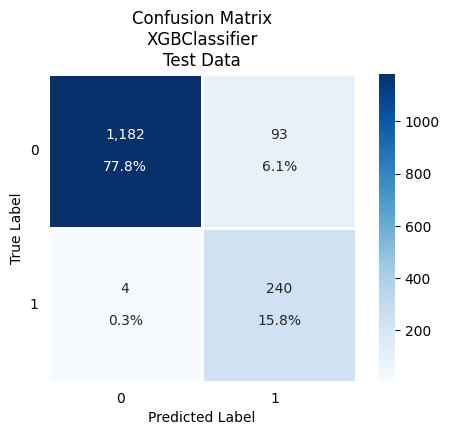

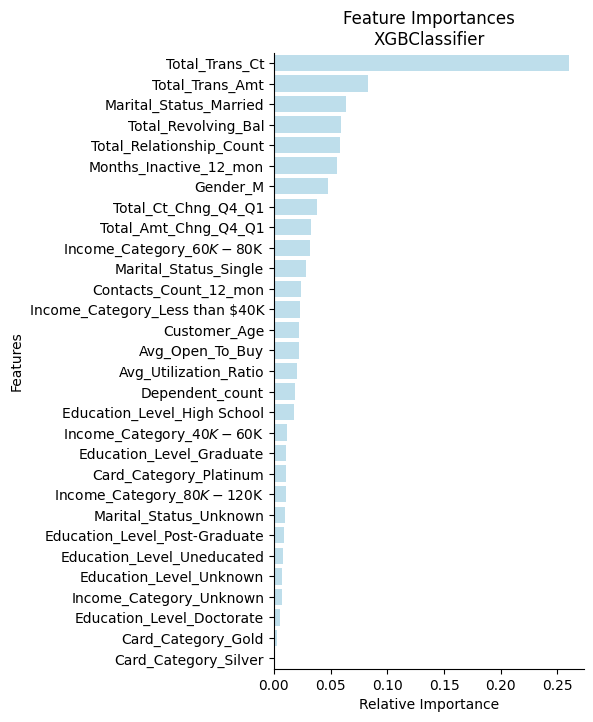

In [87]:
r = get_test_performance(selected, X_test, y_test)
r.index.name = 'Test Scores'

In [88]:
r

,Accuracy,Recall,Precision,F1,objective,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,device,early_stopping_rounds,enable_categorical,eval_metric,feature_types,gamma,grow_policy,importance_type,interaction_constraints,learning_rate,max_bin,max_cat_threshold,max_cat_to_onehot,max_delta_step,max_depth,max_leaves,min_child_weight,missing,monotone_constraints,multi_strategy,n_estimators,n_jobs,num_parallel_tree,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
Test Scores,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
XGBClassifier,0.936,0.984,0.721,0.832,binary:logistic,None,None,None,None,None,None,None,None,False,None,None,3,None,None,None,0.050,None,None,None,None,None,None,None,NaN,None,None,75,None,None,None,None,None,None,5,0.900,None,None,None


In [89]:
res_orig = pd.read_csv(f'{data_dir}/perf_df_all.csv')

In [111]:
res_orig = pd.read_csv(f'{data_dir}/perf_df_all.csv')
res_orig = res_orig.reset_index().rename(columns={'index': 'ind'})
res_orig = res_orig[res_orig['Sampling']=='Original']
res = res_orig.set_index(['Model', 'Sampling'])
sel = res[res['Data']=='Validation'].sort_values(by=['Recall', 'Best CV score'], ascending=[False, False]).head(8)
par = ['learning_rate', 'estimator', 'init', 'n_estimators', 'subsample']
target_cols = ['Recall']+par+['ind']
train_recall = res[res['ind'].isin(sel['ind']-1)][target_cols].rename(columns={'Recall': 'Train Recall'}).reset_index()
validation_recall = sel[target_cols].rename(columns={'Recall': 'Validation Recall'}).reset_index()
out = (pd.merge(train_recall, validation_recall, on=['Model', 'Sampling']+par)
)
out['Score Diff'] = abs(out['Validation Recall'] - out['Train Recall'])
out.sort_values(by=['Validation Recall', 'Score Diff'], ascending=[False, True], inplace=True)
out = out[['Model', 'Sampling', 'Train Recall', 'Validation Recall', 'Score Diff']+par + ['ind_x', 'ind_y']]

out = out[out['Train Recall']!=1]
out['n_estimators'] = out['n_estimators'].astype('Int64')
#out.fillna('')
out

,Model,Sampling,Train Recall,Validation Recall,Score Diff,learning_rate,estimator,init,n_estimators,subsample,ind_x,ind_y
7,XGB,Original,0.992,0.951,0.041,0.050,NaN,NaN,75,0.900,66,67
2,GradientBoosting,Original,0.879,0.827,0.052,0.100,NaN,NaN,100,1.000,18,19
5,GradientBoosting,Original,0.874,0.802,0.072,0.100,NaN,AdaBoostClassifier,100,0.900,42,43
0,Bagging,Original,0.982,0.802,0.180,NaN,NaN,NaN,10,NaN,0,1
6,Bagging,Original,0.998,0.802,0.196,NaN,NaN,NaN,70,NaN,48,49
4,AdaBoost,Original,0.829,0.790,0.039,0.100,DecisionTreeClassifier,NaN,100,NaN,36,37


In [108]:
# res_orig = pd.read_csv(f'{data_dir}/perf_df_all.csv')
# res_orig = res_orig.reset_index().rename(columns={'index': 'ind'})
# res_orig = res_orig[res_orig['Sampling']=='Under']
# res = res_orig.set_index(['Model', 'Sampling'])
# sel = res[res['Data']=='Validation'].sort_values(by=['Recall', 'Best CV score'], ascending=[False, False]).head(7)
# par = ['learning_rate', 'estimator', 'init', 'n_estimators', 'subsample']
# target_cols = ['Recall']+par+['ind']
# train_recall = res[res['ind'].isin(sel['ind']-1)][target_cols].rename(columns={'Recall': 'Train Recall'}).reset_index()
# validation_recall = sel[target_cols].rename(columns={'Recall': 'Validation Recall'}).reset_index()
# out = (pd.merge(train_recall, validation_recall, on=['Model', 'Sampling']+par)
# )
# out['Score Diff'] = abs(out['Validation Recall'] - out['Train Recall'])
# out.sort_values(by=['Validation Recall', 'Score Diff'], ascending=[False, True], inplace=True)
# out = out[['Model', 'Sampling', 'Train Recall', 'Validation Recall', 'Score Diff']+par + ['ind_x', 'ind_y']]

# out = out[out['Train Recall']!=1]
# out['n_estimators'] = out['n_estimators'].astype('Int64')
# #out.fillna('')
# out

In [112]:
res_orig = pd.read_csv(f'{data_dir}/perf_df_all.csv')
res_orig = res_orig.reset_index().rename(columns={'index': 'ind'})
inds = [ind_train, ind_val]
r = res_orig[res_orig['ind'].isin(inds)]
r['n_estimators'] = r['n_estimators'].astype('Int64')
r = r.dropna(axis=1)
r = r.fillna('')
r

,ind,Model,Data,Sampling,Accuracy,Recall,Precision,F1,n_estimators,learning_rate,subsample,Best CV score
66,66,XGB,Train,Original,0.974,0.992,0.866,0.924,75,0.050,0.900,0.934
67,67,XGB,Validation,Original,0.968,0.951,0.865,0.906,75,0.050,0.900,0.934


In [118]:
samp = 'Original'
cols = ['Data', 'Recall', 'Accuracy', 'F1', 'Best CV score', 'n_estimators', 'learning_rate']
out = r[r['Sampling']==samp][cols].sort_values(by=['Recall', 'Best CV score'], ascending=[False, False])
out['Best CV score'] = out['Best CV score'].apply(lambda x: round(x, 2))
out['n_estimators'] = out['n_estimators'].astype('Int64')
out

,Data,Recall,Accuracy,F1,Best CV score,n_estimators,learning_rate
66,Train,0.992,0.974,0.924,0.930,75,0.050
67,Validation,0.951,0.968,0.906,0.930,75,0.050
